In [1]:
from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
# Generate expected return and covariance matrix from time-series
stocks = [ "AMD", "GOOGL", "MSFT", "NVDA"]
#[ "AMD", "GOOGL", "MSFT", "NVDA", "WMT", "AAPL", "AMZN", "TSLA", "JPM", "JNJ","PYPL","EBAY"]

# set number of assets (= number of qubits)
num_assets = len(stocks)
seed = 123

data = YahooDataProvider(
    tickers=stocks,
    start=datetime.datetime(2017, 1, 1),
    end=datetime.datetime(2022, 12, 31)
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
num_assets

4

In [3]:
import yfinance as yf
import pandas as pd

# Set the start and end date
start_date = '2017-01-01'
end_date = '2022-12-31'

# Create placeholder for data
data2 = pd.DataFrame(columns=stocks)

# Fetch the data
for ticker in stocks:
    data2[ticker] = yf.download(ticker, start_date,end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


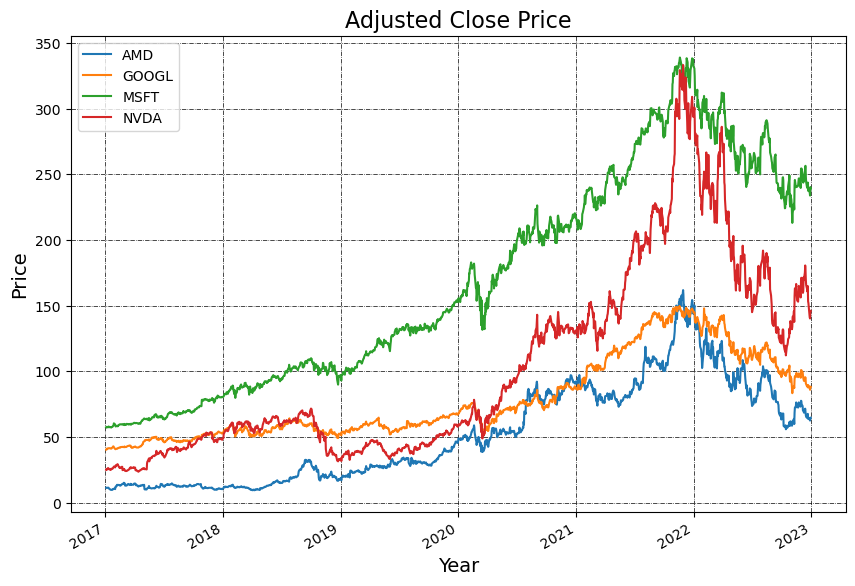

In [4]:
data2.plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [6]:
vqe_res = []
qaoa_res = []
l = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0]
for q in l:
#     q = 1 # set risk factor
    budget = num_assets // 2  # set budget
    penalty = num_assets  # set parameter to scale the budget penalty term

    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
    )
    qp = portfolio.to_quadratic_program()
    
    #VQE
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("qasm_simulator")
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qp)
    vqe_res.append(result.x)

    #QAOA
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("qasm_simulator")
    cobyla = COBYLA()
    cobyla.set_options(maxiter=250)
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    qaoa_res.append(result.x)

In [7]:
from scipy.optimize import minimize
import random
def portfolio(weights):
  weights = np.array(weights)
  expected_return = np.sum((returns.mean()* weights) * 252)
  expected_vol = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
  sharpe_r = expected_return/expected_vol
  return np.array([expected_return,expected_vol,sharpe_r])

def sr_negate(weights):
  neg_sr = portfolio(weights)[2] * -1
  return neg_sr

def weight_check(weights):
  weights_sum = np.sum(weights)
  return weights_sum - 1
def insert_tuples(n):
    return [(0, 1) for i in range(n)]

In [8]:
vqe_assets=[]
vqe_sharpe = []
vqe_return = []
vqe_vol = []
for x in vqe_res:
    assets = []
    for i in range(len(x)):
        if(x[i] == 1):
            assets.append(stocks[i])
    vqe_assets.append(assets)
    data = pd.DataFrame(columns=assets)
    data[assets] = data2[assets]
    n = len(assets)
    returns=data.pct_change()
    weights = [random.random() for _ in range(n)]
    sum_weights = sum(weights)
    weights = [1*w/sum_weights for w in weights]
    constraints = ({'type':'eq','fun':weight_check})
    initial_guess = weights
    bounds=insert_tuples(n)
    results = minimize(sr_negate,weights,method='SLSQP',bounds=bounds,constraints=constraints)
    optimized_metrics = portfolio(results.x)
    vqe_return.append("Expected Return={:.2f}%".format(optimized_metrics[0]*100))
    vqe_vol.append("Expected votality={:.2f}%".format(optimized_metrics[1]*100))
    vqe_sharpe.append("Sharpe Ratio={:.2f}".format(optimized_metrics[2]))

In [9]:
qaoa_assets=[]
qaoa_sharpe = []
qaoa_return = []
qaoa_vol = []
for x in qaoa_res:
    assets = []
    for i in range(len(x)):
        if(x[i] == 1):
            assets.append(stocks[i])
    qaoa_assets.append(assets)
    data = pd.DataFrame(columns=assets)
    data[assets] = data2[assets]
    n = len(assets)
    returns=data.pct_change()
    weights = [random.random() for _ in range(n)]
    sum_weights = sum(weights)
    weights = [1*w/sum_weights for w in weights]
    constraints = ({'type':'eq','fun':weight_check})
    initial_guess = weights
    bounds=insert_tuples(n)
    results = minimize(sr_negate,weights,method='SLSQP',bounds=bounds,constraints=constraints)
    optimized_metrics = portfolio(results.x)
    qaoa_return.append("Expected Return={:.2f}%".format(optimized_metrics[0]*100))
    qaoa_vol.append("Expected votality={:.2f}%".format(optimized_metrics[1]*100))
    qaoa_sharpe.append("Sharpe Ratio={:.2f}".format(optimized_metrics[2]))

In [10]:
for x in range(len(l)):
    print("q = ",l[x],"\nVQE : ",vqe_assets[x], vqe_return[x],vqe_vol[x],vqe_sharpe[x],"\nQAOA : ", qaoa_assets[x],qaoa_return[x],qaoa_vol[x],qaoa_sharpe[x], "\n")

q =  0.1 
VQE :  ['AMD', 'NVDA'] Expected Return=43.29% Expected votality=48.73% Sharpe Ratio=0.89 
QAOA :  ['AMD', 'NVDA'] Expected Return=43.29% Expected votality=48.73% Sharpe Ratio=0.89 

q =  0.2 
VQE :  ['AMD', 'NVDA'] Expected Return=43.29% Expected votality=48.73% Sharpe Ratio=0.89 
QAOA :  ['AMD', 'NVDA'] Expected Return=43.30% Expected votality=48.73% Sharpe Ratio=0.89 

q =  0.3 
VQE :  ['AMD', 'NVDA'] Expected Return=43.29% Expected votality=48.73% Sharpe Ratio=0.89 
QAOA :  ['AMD', 'NVDA'] Expected Return=43.30% Expected votality=48.73% Sharpe Ratio=0.89 

q =  0.4 
VQE :  ['AMD', 'MSFT'] Expected Return=31.55% Expected votality=30.91% Sharpe Ratio=1.02 
QAOA :  ['AMD', 'MSFT'] Expected Return=31.54% Expected votality=30.91% Sharpe Ratio=1.02 

q =  0.5 
VQE :  ['MSFT', 'NVDA'] Expected Return=30.87% Expected votality=31.00% Sharpe Ratio=1.00 
QAOA :  ['AMD', 'MSFT'] Expected Return=31.55% Expected votality=30.92% Sharpe Ratio=1.02 

q =  0.6 
VQE :  ['MSFT', 'NVDA'] Expec